In [22]:
import numpy as np
import pandas as pd
import hvplot.pandas  # Not used in your code, so you may remove this
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
from unidecode import unidecode
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

In [2]:
# Adjust display options
pd.set_option('display.max_columns', None)  # None means no limit

In [4]:
# Load the CSV files into Pandas DataFrames
hallucinations_df = pd.read_csv('data/hallucinations_df_for_r.csv')

In [5]:
hallucinations_df.rename(columns={'Mouth.mean': 'mouth_strength'}, inplace=True)

In [6]:
# Recreate regression models from R to create a forest plot

model_full = 'visual_vividness ~ mouth_strength + head_strength + foot_strength + ' \
             'hand_strength + torso_strength + visual_strength + interoceptive_strength + (1 | id)'

# Fit the mixed effects model
model = smf.mixedlm(model_full, hallucinations_df, groups=hallucinations_df['id'])
result = model.fit()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
result.fe_params

Intercept                -0.064216
mouth_strength            0.362134
head_strength             0.337656
foot_strength             0.359374
hand_strength             0.527733
torso_strength            0.447445
visual_strength           0.698239
interoceptive_strength   -0.037950
1 | id                   -0.000058
dtype: float64

In [13]:
# Copy the dataset to avoid modifying the original
scaled_hallucinations_df = hallucinations_df.copy()

# List of predictor variables to scale
predictors_to_scale = ['mouth_strength', 'head_strength', 'foot_strength', 
                       'hand_strength', 'torso_strength', 'interoceptive_strength', 'description_length']

# Apply z-scoring (standardization) to the predictors
scaler = StandardScaler()
scaled_hallucinations_df[predictors_to_scale] = scaler.fit_transform(scaled_hallucinations_df[predictors_to_scale])

# Fit a GLM instead of OLS
full_model = smf.glm(formula='visual_vividness ~ mouth_strength + head_strength +'
                             ' foot_strength + hand_strength + torso_strength +'
                             '  + description_length',
                     data=scaled_hallucinations_df, 
                     family=sm.families.Gaussian()).fit()

# Print the model summary
print(full_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       visual_vividness   No. Observations:                 4057
Model:                            GLM   Df Residuals:                     4050
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          9.4484
Method:                          IRLS   Log-Likelihood:                -10309.
Date:                Sun, 06 Apr 2025   Deviance:                       38266.
Time:                        15:41:52   Pearson chi2:                 3.83e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03943
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.0560      0

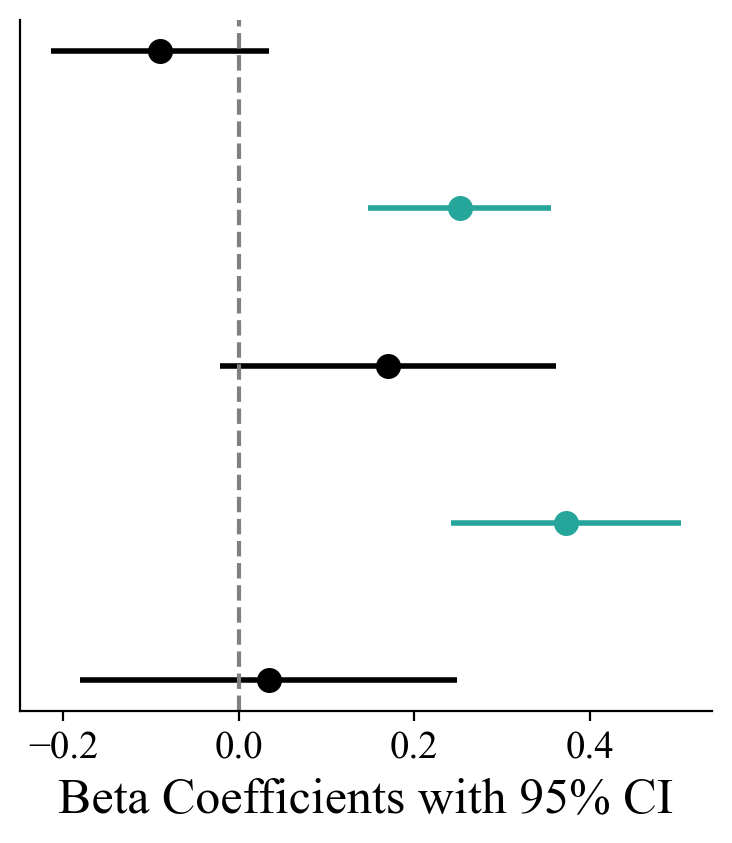

In [14]:
# Extract GLM parameters (betas)
glm_params = full_model.params

# Extract confidence intervals
conf_int = full_model.conf_int()

# Extract p-values
p_values = full_model.pvalues

# Determine significance based on p-values < 0.05
significant_effects = p_values < 0.05

# Identify the direction of the significant effects
significant_positive = significant_effects & (glm_params > 0)
significant_negative = significant_effects & (glm_params < 0)

# Remove intercept and 'description_length'
glm_params = glm_params.drop(['Intercept', 'description_length'])
conf_int = conf_int.loc[glm_params.index]  # Filter confidence intervals
p_values = p_values.loc[glm_params.index]  # Filter p-values
significant_effects = significant_effects.loc[glm_params.index]  # Filter significance

# Set the font to Times New Roman globally with font size 18
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

# Create the plot with a size suitable for single-column fitting
fig, ax = plt.subplots(figsize=(4, 4 * 4 / 3.5))  # 3.5 inches width and 4:3 aspect ratio

# Define indices dynamically after filtering
indices_to_plot = np.arange(len(glm_params))

# Loop through the GLM betas and plot them
for idx, i in enumerate(indices_to_plot):
    # Extract estimates and confidence intervals
    est = glm_params.iloc[i]
    lower, upper = conf_int.iloc[i]

    # Determine color based on significance
    if significant_effects.iloc[i]:
        color = '#26A69A' if est > 0 else '#FF7043'
    else:
        color = 'black'

    # Plot the error bar with capsize set to 0
    ax.errorbar(est, idx, xerr=[[est - lower], [upper - est]], fmt='o', color=color, 
                ecolor=color, elinewidth=2, capsize=0, markersize=8)

# Set the y-axis labels to match the predictor names
ax.set_yticks(np.arange(len(glm_params)))
ax.set_yticklabels(glm_params.index)

# Add a vertical line at x=0 for reference
ax.axvline(x=0, color='gray', linestyle='--')

# Set axis labels and title
ax.set_xlabel('Beta Coefficients with 95% CI')
ax.set_title('')

# Adjust tick parameters
ax.tick_params(axis='x', labelsize=14)
# ax.tick_params(axis='y', labelsize=0.1, length=0)  # Hide y-axis tick labels and ticks
ax.set_yticklabels([])
ax.set_yticks([])

# Invert the y-axis to have the first index at the top
ax.invert_yaxis()

# Layout and style adjustments
plt.tight_layout()
sns.despine()  # Remove the top and right spines

plt.savefig('glm_forest_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


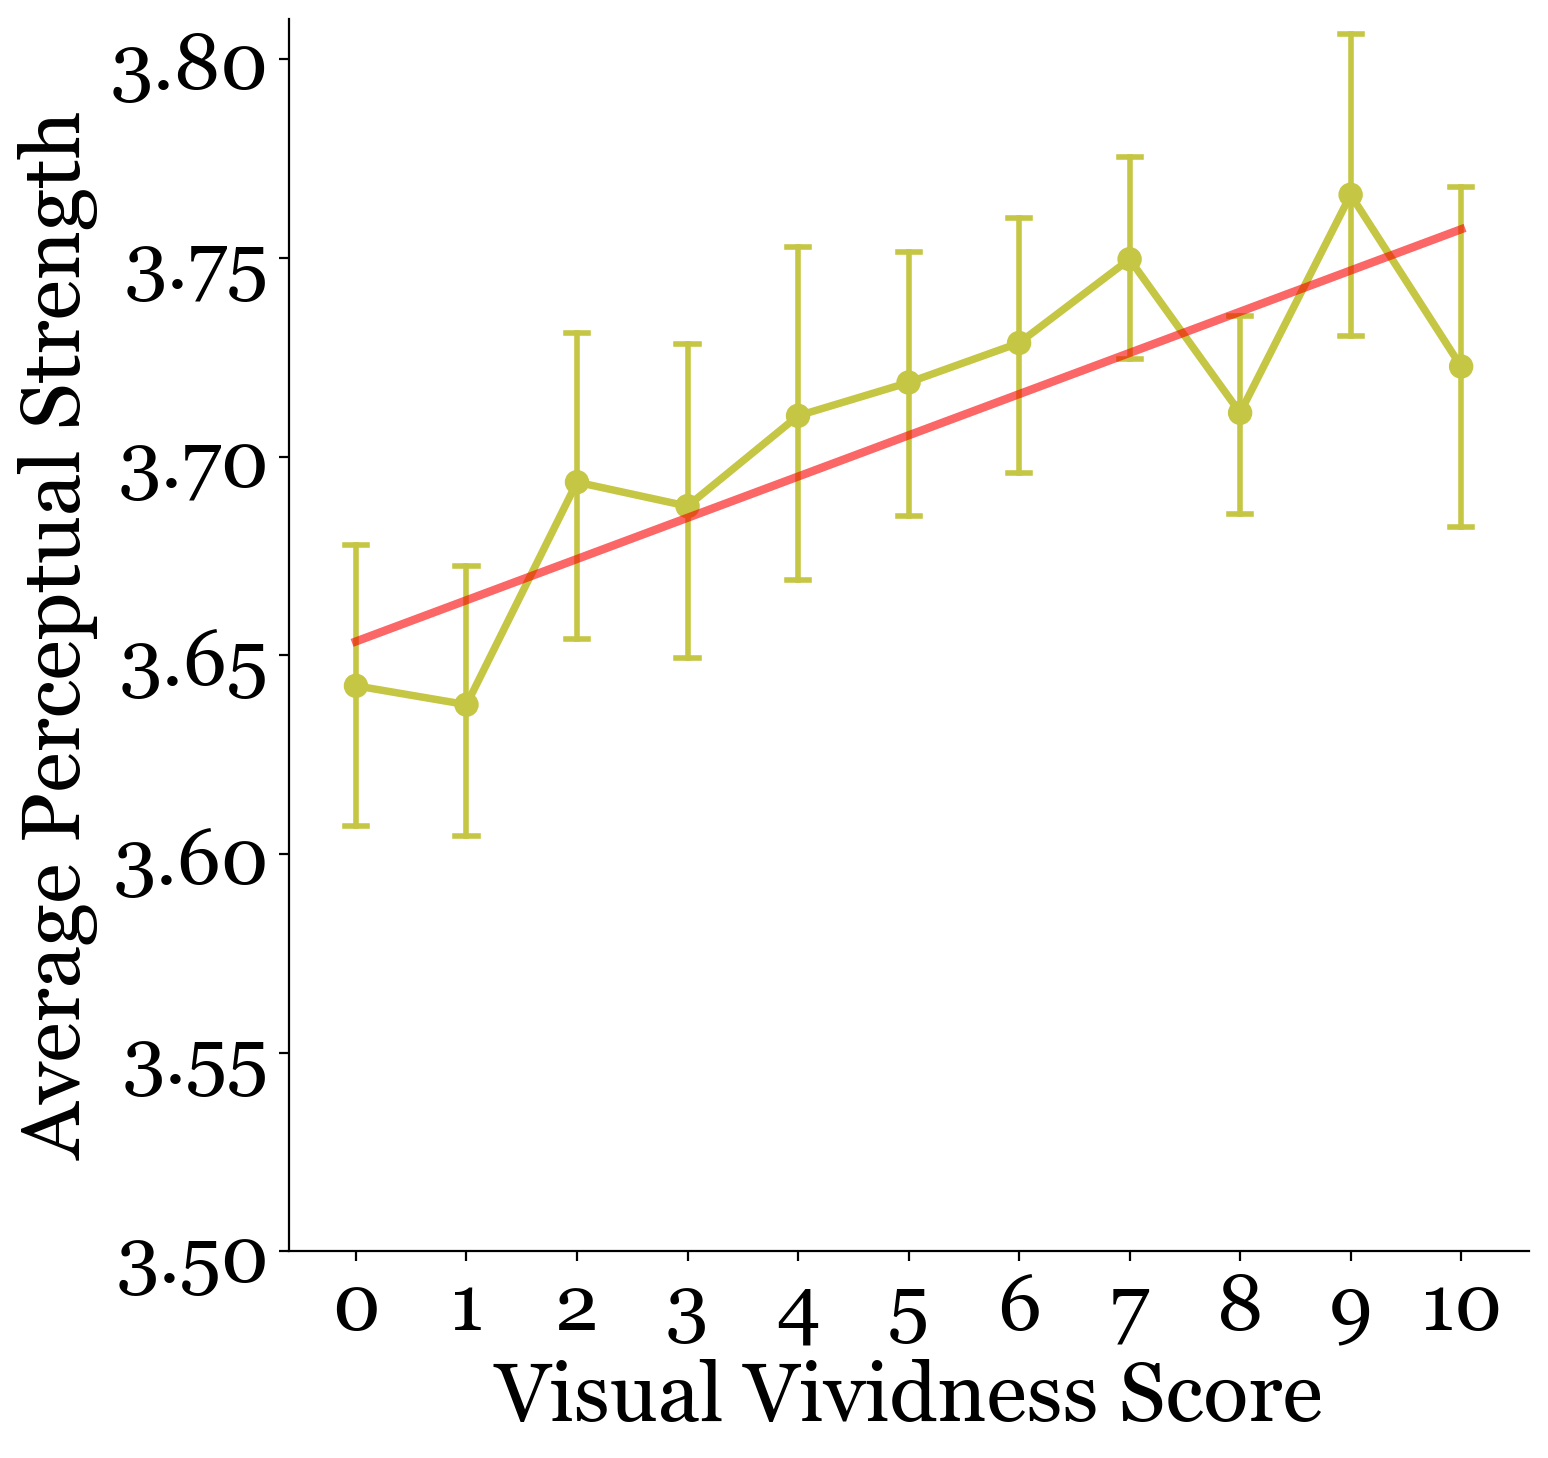

In [21]:
# Set the font to Georgia globally
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['font.size'] = 40  

# Create a figure for plotting
plt.figure(figsize=(8, 8))

# Create a point plot with error bars
sns.pointplot(data=hallucinations_df, x='visual_vividness', y='perceptual_strength', 
              color='#c5c643', markers='o', linestyles='-', capsize=0.2, errwidth=2, dodge=True)

# Overlay a regression plot to show the linear trend
sns.regplot(data=hallucinations_df, x='visual_vividness', y='perceptual_strength', scatter=False, 
            color='green', ci=None, line_kws={"color": "#f90000", "alpha": 0.6, "lw": 3})

# Set labels and title
plt.xlabel('Visual Vividness Score', fontsize=30)
plt.ylabel('Average Perceptual Strength', fontsize=30)
plt.title('', fontdict={'family': 'Georgia', 'weight': 'normal', 'size': 1})

# Adjust the limits and tick marks
plt.ylim(3.5, 3.81)
plt.tick_params(axis='both', labelsize=28)

# Remove the border
sns.despine()

plt.savefig('visual_vividness_pointplot.png', dpi=300, bbox_inches='tight')

plt.show()

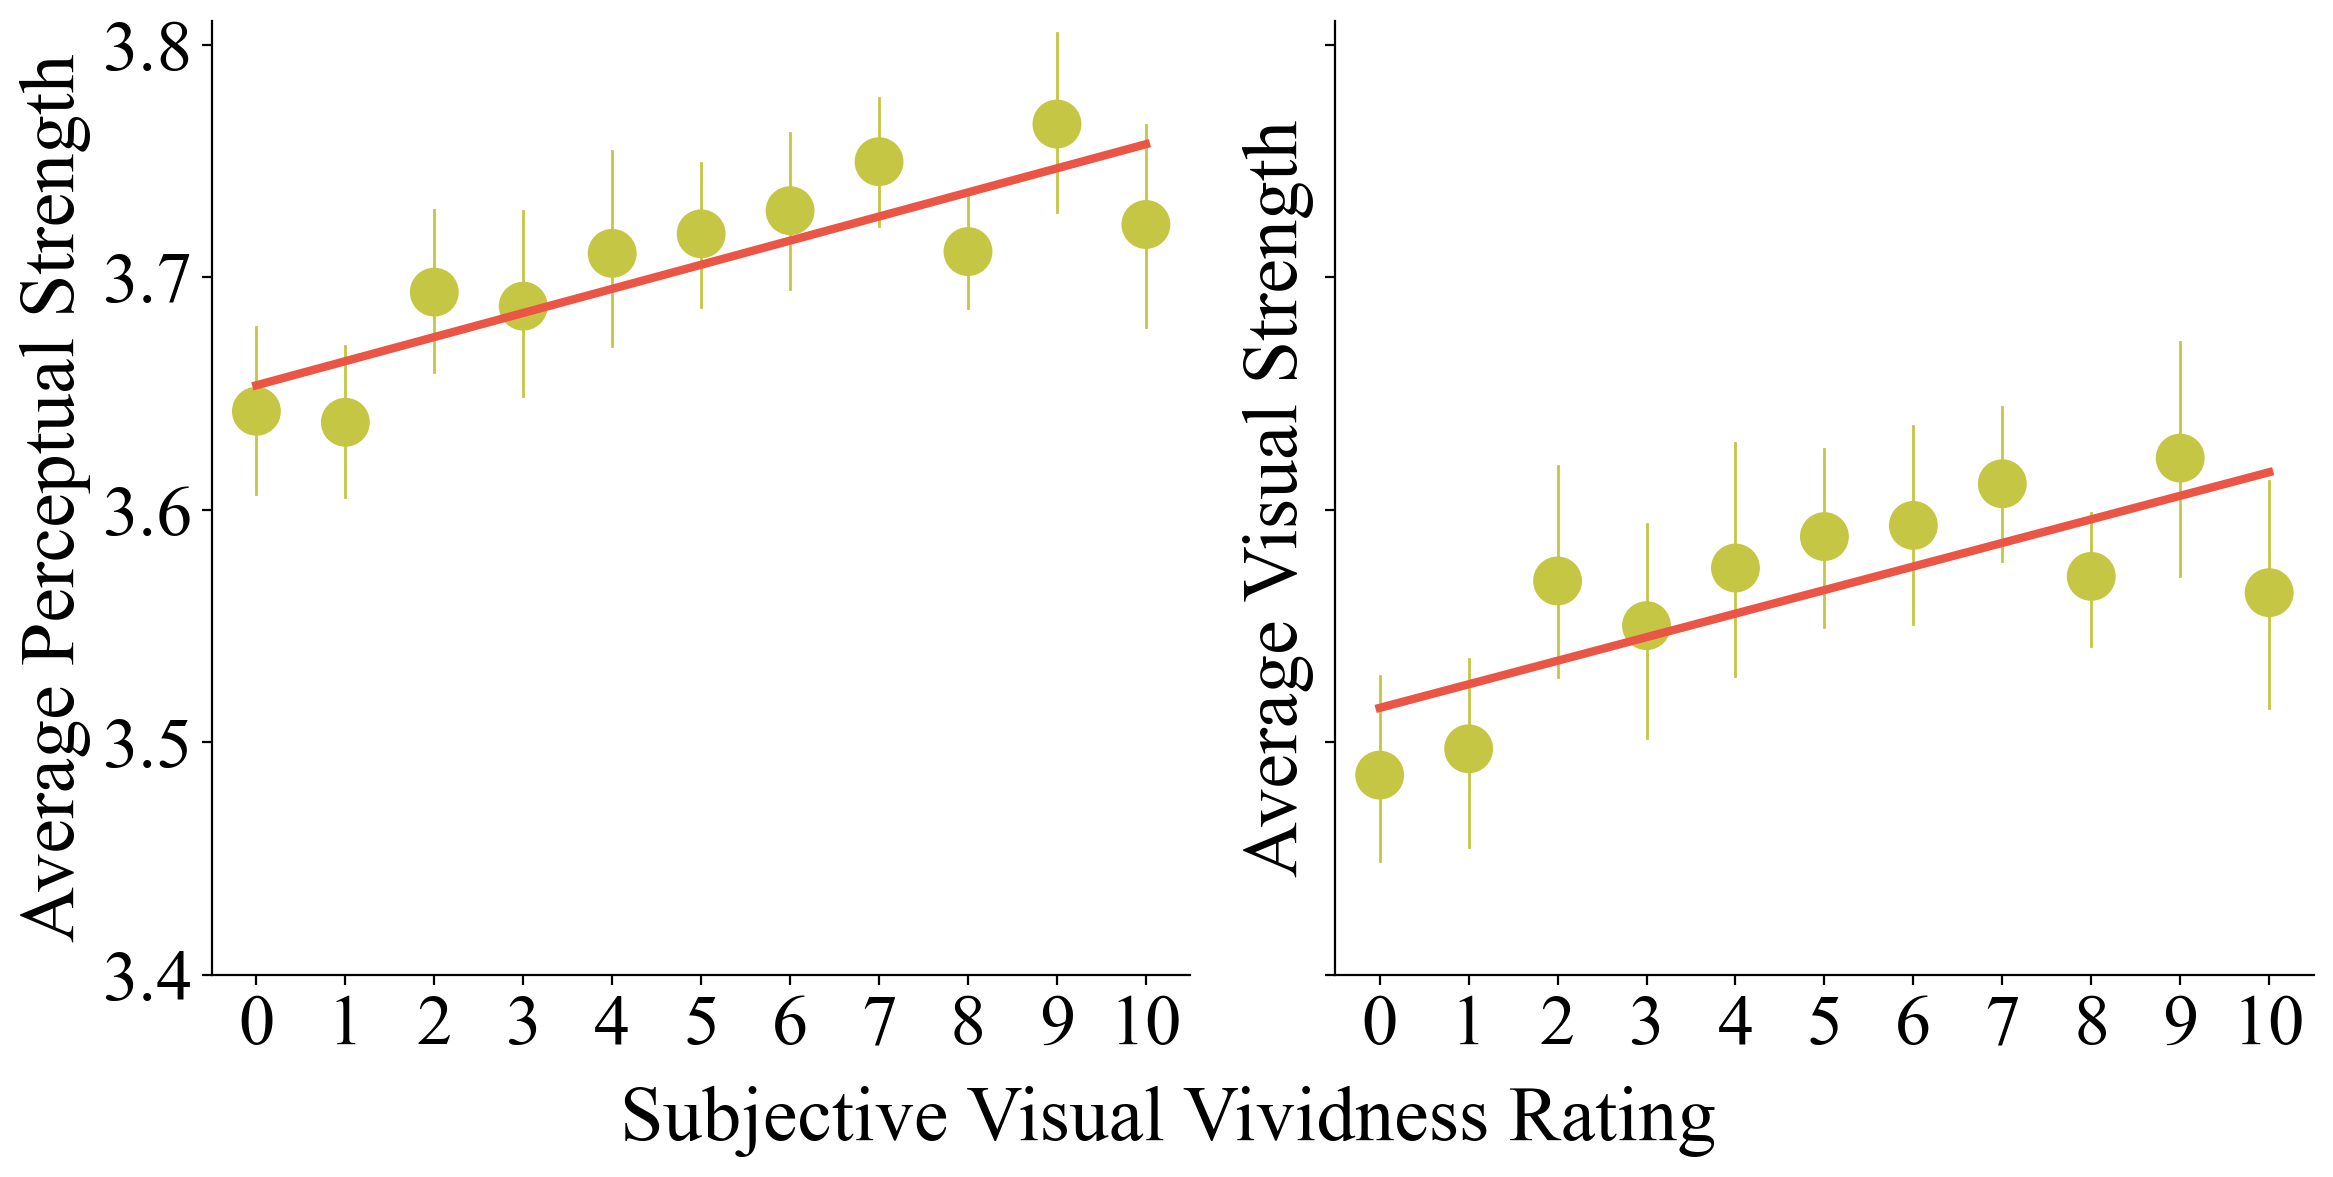

In [404]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font to Times New Roman globally
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18  # Slightly bigger font for readability

# Choose color palette
point_color = "#c5c643"   # Light Blue
scatter_color = "#c5c643" # Light Blue
line_color = "#ea5545"    # Muted Red
error_bar_color = "#c5c643"  # Light Blue

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Reduced figure size

# First point plot: Perceptual Strength
sns.pointplot(data=hallucinations_df, x='visual_vividness', y='perceptual_strength', 
              color=point_color, markers='o', linestyles='-', capsize=0, errwidth=1, join=False,
              dodge=True, errcolor=error_bar_color, scale=2, ax=axes[0])

# Overlay regression plot
sns.regplot(data=hallucinations_df, x='visual_vividness', y='perceptual_strength', scatter=False, 
            color=scatter_color, ci=None, line_kws={"color": line_color, "alpha": 1, "lw": 3}, ax=axes[0])

# First plot labels
axes[0].set_xlabel('')  # Remove individual x labels
axes[0].set_ylabel('Average Perceptual Strength', fontsize=28)  # Slightly larger font

# Second point plot: Visual Strength
sns.pointplot(data=hallucinations_df, x='visual_vividness', y='visual_strength', 
              color=point_color, markers='o', linestyles='-', capsize=0, errwidth=1, join=False,
              dodge=True, errcolor=error_bar_color, scale=2, ax=axes[1])

# Overlay regression plot
sns.regplot(data=hallucinations_df, x='visual_vividness', y='visual_strength', scatter=False, 
            color=scatter_color, ci=None, line_kws={"color": line_color, "alpha": 1, "lw": 3}, ax=axes[1])

# Second plot labels
axes[1].set_xlabel('')  # Remove individual x labels
axes[1].set_ylabel('Average Visual Strength', fontsize=28)  # Slightly larger font

# Adjust the limits and tick marks
for ax in axes:
    ax.set_ylim(3.4, 3.81)
    ax.tick_params(axis='both', labelsize=26)  # Slightly larger tick labels
    sns.despine(ax=ax)
    # Adjust x-axis limits to add padding
    x_min, x_max = ax.get_xlim()
    x_range = x_max - x_min
    ax.set_xlim(x_min - 0.05 * x_range, x_max + 0.05 * x_range)  # Add 5% padding on both sides

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.2)  # Decreased space between subplots

# Add a common x-axis label, now closer to the plots
fig.text(0.5, 0.02, 'Subjective Visual Vividness Rating', ha='center', fontsize=28)

# Adjust layout with less space below the plots
plt.tight_layout(rect=[0, 0.04, 1, 1])  # Reduced space at the bottom

# Save the figure for manuscript integration
plt.savefig('visual_vividness_facetplot_pretty.png', dpi=300, bbox_inches='tight')

plt.show()

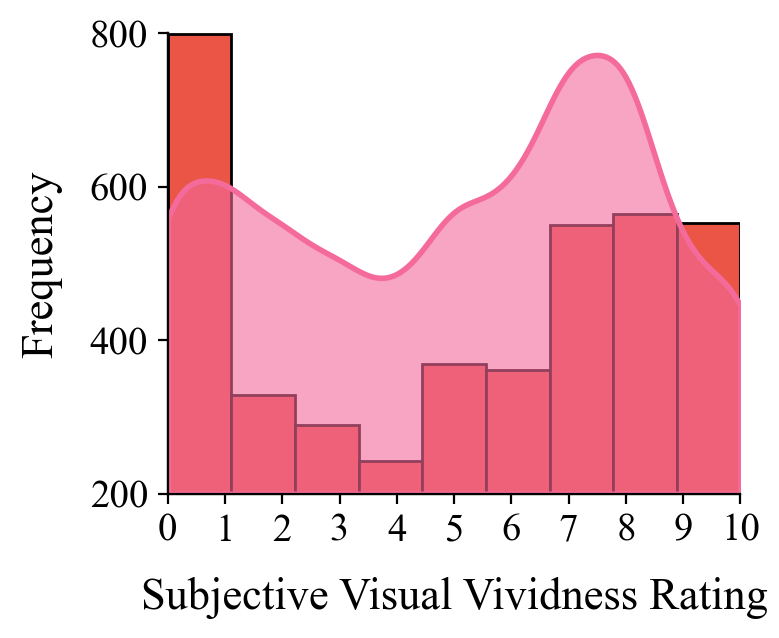

In [20]:
# Set the font to Times New Roman and font size to 18
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 17

# Create a new figure with dimensions 4x4 inches
fig, ax = plt.subplots(figsize=(4.2, 3.5))

# Plot: Histogram and KDE
sns.histplot(data=hallucinations_df, x='visual_vividness', bins=9, color='#ea5545', alpha=1, ax=ax)
kde_ax = ax.twinx()
sns.kdeplot(data=hallucinations_df, x='visual_vividness', color='#f46a9b', fill=True, alpha=0.6, linewidth=2, ax=kde_ax, cut=0)
kde_ax.set_yticks([])  # Hide y-axis labels and ticks for KDE plot
kde_ax.set_ylabel('')

# Set labels and limits
ax.set_xlabel('Subjective Visual Vividness Rating', fontsize=16, labelpad=10)
ax.set_ylabel('Frequency', fontsize=16, labelpad=10)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim(0, 10)
ax.set_ylim(200, 800)
ax.set_xticks(range(11))

# Adjust layout
plt.tight_layout()
sns.despine()  # Remove the top and right spines

# Save the figure
plt.savefig('visual_vividness_histogram_kde.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()